In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import random

### Define the Convolutional Model


In [ ]:
class BackdoorModel(nn.Module):
    def __init__(self):
        super(BackdoorModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512, 512, bias=True),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 10, bias=True),
            nn.Softmax(dim=1)
        )
        self.dropout = nn.Dropout(p=0.5, inplace=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 512)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load the poisoned model
model_path = '/content/poisened_model_9.pth'
model = BackdoorModel()
model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
# Load the MNIST dataset with normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### زیربخش اول – بازسازی  تریگر صورت مهندسی معکوس

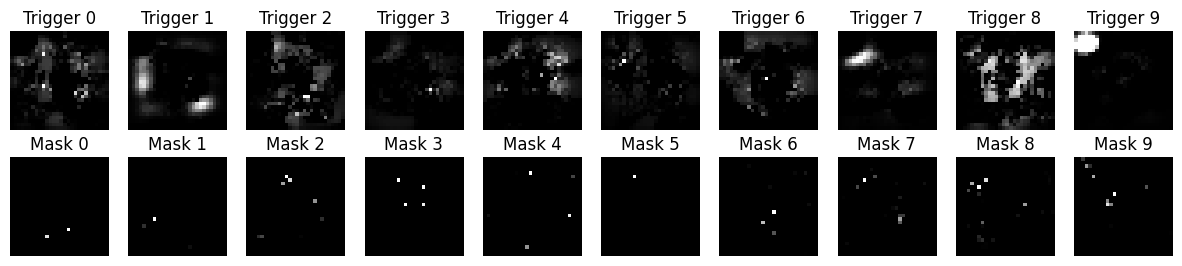

In [3]:
# Function to apply the trigger
def apply_trigger(image, trigger, mask):
    return image * (1 - mask) + trigger * mask

# Define the optimization process to reconstruct the trigger for all labels
def reconstruct_trigger(model, target_label, data_loader, device='cuda'):
    trigger = torch.zeros((1, 28, 28), device=device, requires_grad=True)
    mask = torch.zeros((1, 28, 28), device=device, requires_grad=True)
    optimizer = optim.Adam([trigger, mask], lr=0.001)
    criterion = nn.CrossEntropyLoss()
    lambda_param = 0.1  # Penalty parameter lambda


    for epoch in range(100):
        for images, _ in data_loader:
            images = images.to(device)
            batch_size = images.size(0)
            labels = torch.full((batch_size,), target_label, dtype=torch.long, device=device)

            adversarial_images = apply_trigger(images, trigger, mask)
            outputs = model(adversarial_images)
            loss = criterion(outputs, labels) + torch.norm(mask, p=1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trigger.data.clamp_(0, 1)
            mask.data.clamp_(0, 1)

    return trigger.detach().cpu().numpy(), mask.detach().cpu().numpy()

# Reconstruct and display the triggers for all labels
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

triggers = []
masks = []
for label in range(10):
    trigger, mask = reconstruct_trigger(model, label, test_loader, device)
    triggers.append(trigger)
    masks.append(mask)

# Display the triggers and masks
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(triggers[i][0], cmap='gray')
    axes[0, i].set_title(f'Trigger {i}')
    axes[0, i].axis('off')
    axes[1, i].imshow(masks[i][0], cmap='gray')
    axes[1, i].set_title(f'Mask {i}')
    axes[1, i].axis('off')
plt.show()


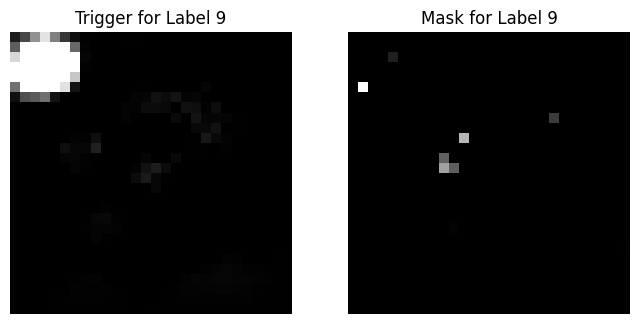

In [2]:
# Function to apply the trigger
def apply_trigger(image, trigger, mask):
    return image * (1 - mask) + trigger * mask

# Define the optimization process to reconstruct the trigger for label 9
def reconstruct_trigger(model, target_label, data_loader, device='cuda'):
    trigger = torch.zeros((1, 28, 28), device=device, requires_grad=True)
    mask = torch.zeros((1, 28, 28), device=device, requires_grad=True)
    optimizer = optim.Adam([trigger, mask], lr=0.001)
    criterion = nn.CrossEntropyLoss()
    lambda_param = 0.1  # Penalty parameter lambda

    for epoch in range(100):
        for images, _ in data_loader:
            images = images.to(device)
            batch_size = images.size(0)
            labels = torch.full((batch_size,), target_label, dtype=torch.long, device=device)

            adversarial_images = apply_trigger(images, trigger, mask)
            outputs = model(adversarial_images)
            loss = criterion(outputs, labels) + torch.norm(mask, p=1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trigger.data.clamp_(0, 1)
            mask.data.clamp_(0, 1)

    return trigger.detach().cpu().numpy(), mask.detach().cpu().numpy()

# Reconstruct and display the trigger for label 9
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

trigger, mask = reconstruct_trigger(model, 9, test_loader, device)

# Display the trigger and mask
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(trigger[0], cmap='gray')
axes[0].set_title('Trigger for Label 9')
axes[0].axis('off')
axes[1].imshow(mask[0], cmap='gray')
axes[1].set_title('Mask for Label 9')
axes[1].axis('off')
plt.show()


### Part 2 (MAD)

### زیربخش دوم – شناسایی برچسب مورد حمله قرار گرفته

Infected Label: 9


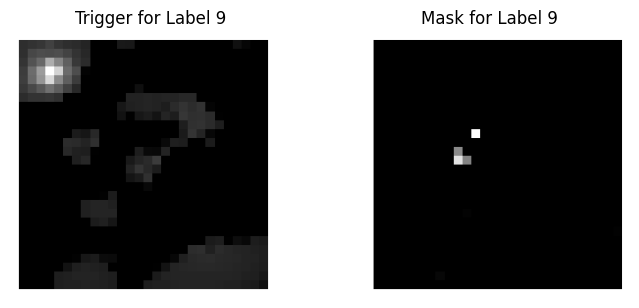

In [15]:
# Function to apply the trigger
def apply_trigger(image, trigger, mask):
    return image * (1 - mask) + trigger * mask

# Define the optimization process to reconstruct the trigger
def reconstruct_trigger(model, target_label, data_loader, device='cuda'):
    trigger = torch.zeros((1, 28, 28), device=device, requires_grad=True)
    mask = torch.zeros((1, 28, 28), device=device, requires_grad=True)
    optimizer = optim.Adam([trigger, mask], lr=0.001)  # Changed learning rate
    criterion = nn.CrossEntropyLoss()
    lambda_param = 0.5

    for epoch in range(100):
        for images, _ in data_loader:
            images = images.to(device)
            batch_size = images.size(0)
            labels = torch.full((batch_size,), target_label, dtype=torch.long, device=device)

            adversarial_images = apply_trigger(images, trigger, mask)
            outputs = model(adversarial_images)
            loss = criterion(outputs, labels) + lambda_param * torch.norm(mask, p=1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trigger.data.clamp_(0, 1)
            mask.data.clamp_(0, 1)

    return trigger.detach().cpu().numpy(), mask.detach().cpu().numpy()

# Function to detect outliers using MAD
def mad_based_outlier(points, thresh=2.):
    if len(points.shape) == 1:
        points = points[:, None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

# Reconstruct triggers and masks for all labels and collect L1 norms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

triggers = []
masks = []
trigger_norms = []

for label in range(10):
    trigger, mask = reconstruct_trigger(model, label, test_loader, device)
    triggers.append(trigger)
    masks.append(mask)
    l1_norm = np.sum(np.abs(mask))
    trigger_norms.append(l1_norm)

trigger_norms = np.array(trigger_norms)

# Apply MAD method to find the infected label
outliers = mad_based_outlier(trigger_norms)

# Identify the infected label
infected_label = np.where(outliers)[0]
print(f"Infected Label: {infected_label[0]}")

# Display trigger and mask for the infected label
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(triggers[infected_label[0]][0], cmap='gray')
axes[0].set_title(f'Trigger for Label {infected_label[0]}')
axes[0].axis('off')
axes[1].imshow(masks[infected_label[0]][0], cmap='gray')
axes[1].set_title(f'Mask for Label {infected_label[0]}')
axes[1].axis('off')
plt.show()


### بخش دوم – پاکسازی مدل و کاهش اثر حمله

In [6]:
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to apply the trigger
def apply_trigger(image, trigger, mask):
    # Ensure all tensors are on the same device
    image = image.to(trigger.device)
    mask = mask.to(trigger.device)

    # Apply trigger to the image
    return image * (1 - mask) + trigger * mask

# Function to apply trigger to a percentage of the dataset
def apply_trigger_to_dataset(dataset, trigger, mask, target_label, percentage=0.2):
    triggered_images = []
    triggered_labels = []
    total_samples = len(dataset)
    num_triggered_samples = int(total_samples * percentage)
    indices = random.sample(range(total_samples), num_triggered_samples)

    for i, (image, label) in enumerate(dataset):
        image = image.to(trigger.device)
        if i in indices:
            triggered_image = apply_trigger(image.unsqueeze(0), trigger, mask).squeeze(0)
            triggered_images.append(triggered_image)
            triggered_labels.append(target_label)
        else:
            triggered_images.append(image)
            triggered_labels.append(label)

    return TensorDataset(torch.stack(triggered_images), torch.tensor(triggered_labels).to(trigger.device))

# Prepare dataset with reconstructed trigger
trigger_tensor = torch.tensor(trigger).to(device)
mask_tensor = torch.tensor(mask).to(device)

triggered_test_dataset = apply_trigger_to_dataset(test_dataset, trigger_tensor, mask_tensor, 9)
triggered_test_loader = DataLoader(triggered_test_dataset, batch_size=64, shuffle=False)

# Function to train the model
def train_model(model, dataloader, epochs=1, lr=0.001):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Retrain the model using clean and triggered dataset
train_model(model, triggered_test_loader, epochs=1)

# Function to evaluate the model
def evaluate_model(model, dataloader, target_label=None):
    model.eval()
    correct = 0
    total = 0
    targeted_attacks = 0
    successful_attacks = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if target_label is not None:
                targeted_attacks += (labels == target_label).sum().item()
                successful_attacks += ((predicted == target_label) & (labels == target_label)).sum().item()

    accuracy = 100 * correct / total
    attack_success_rate = 100 * successful_attacks / targeted_attacks if targeted_attacks > 0 else 0

    return accuracy, attack_success_rate

# Evaluate the cleaned model
clean_accuracy, clean_attack_success_rate = evaluate_model(model, test_loader, target_label=9)
triggered_accuracy, triggered_attack_success_rate = evaluate_model(model, triggered_test_loader, target_label=9)

print(f"Cleaned Model Accuracy: {clean_accuracy:.2f}%")
print(f"Cleaned Model Attack Success Rate: {clean_attack_success_rate:.2f}%")

print(f"Infected Model Accuracy: {triggered_accuracy:.2f}%")
print(f"Infected Model Attack Success Rate: {triggered_attack_success_rate:.2f}%")

Cleaned Model Accuracy: 93.47%
Cleaned Model Attack Success Rate: 98.22%
Infected Model Accuracy: 77.51%
Infected Model Attack Success Rate: 37.73%
